## FITclass Utilities

This notebook is an **extension of the FITclass_main notebook** as part of the FITclass project, which aim is to classify fitness time series data. Main parts of this notebook are a DataExplorer functionality to visualize samples of the dataset as well as correlation plot generation for the two data channels `heart_rate` and `mean_speed`.

#### Raw Data Visualization

In [1]:
! head -1 F:/datasets/endomondoHR_proper_meanspeed.json

{"longitude": [24.64977040886879, 24.65014273300767, 24.650910682976246, 24.650668865069747, 24.649145286530256, 24.648349760100245, 24.645312326028943, 24.6447014529258, 24.644415881484747, 24.641415160149336, 24.63826850987971, 24.636211171746254, 24.634060626849532, 24.63249195367098, 24.631360983476043, 24.629418225958943, 24.625693140551448, 24.62388290092349, 24.621391966938972, 24.62025227956474, 24.61888753809035, 24.617006219923496, 24.615299999713898, 24.614676302298903, 24.612943679094315, 24.61235510185361, 24.61154105141759, 24.610843928530812, 24.61042357608676, 24.60953777655959, 24.608315024524927, 24.606816424056888, 24.605027558282018, 24.603541865944862, 24.602169329300523, 24.600177453830838, 24.599060313776135, 24.597142953425646, 24.596376596018672, 24.594232169911265, 24.592483872547746, 24.591050064191222, 24.589767884463072, 24.58789142780006, 24.583472656086087, 24.582278402522206, 24.580545527860522, 24.579513799399137, 24.57896520383656, 24.57808376289904, 2

#### DataLoader Functionality

This implemented DataLoader gives the opportunity to read samples out of the raw data (as shown above) and call them via their index position. This is for instance helpful when plotting certain time series data (e.g. from a specific data sample).

In [5]:
import json
from pprint import *
from tqdm.notebook import tqdm

In [6]:
class Endomondo_DataLoader():
    def __init__(self, datapath):
        self.datapath = datapath
        self.sports_classes = ['bike', 'bike (transport)', 'run', 'mountain bike', 'rowing', 'orienteering', 'tennis', 'kayaking', 'indoor cycling', 'skate', 'cross-country skiing', 'core stability training', 'walk', 'hiking', 'weight training', 'elliptical', 'soccer', 'treadmill running', 'basketball', 'swimming', 'circuit training', 'gymnastics', 'snowshoeing', 'snowboarding', 'yoga', 'fitness walking', 'roller skiing', 'horseback riding', 'downhill skiing', 'aerobics', 'stair climing', 'golf', 'badminton', 'treadmill walking', 'table tennis', 'pilates', 'sailing', 'kite surfing', 'climbing', 'squash', 'martial arts', 'windsurfing', 'rugby']
        
    def __len__(self):
        with open(self.datapath, "r") as file:
            self.line_count = 0
            for line in file:
                if line != "\n":
                    self.line_count += 1
        
        return self.line_count
        
    def get_available_datachannels(self):
        demo_sample = self.load_number_of_fitness_samples(nr_maximum_sample=1)[0]
        return list(demo_sample.keys())
        
    def load_number_of_fitness_samples(self, nr_maximum_sample=1, start_idx=0):
        sample_list = []
        
        with open(self.datapath, encoding='utf8') as file:
            for index, line in enumerate(file):
                
                # start at start_idx first (if set else than zero)
                if index < start_idx:
                    continue
    
                # json only supports double quotations
                line = line.replace("\'", "\"")  

                # save properties of json object
                sample_list.append(json.loads(line))
                
                # stop after nr_maximum_sample samples
                if index == (nr_maximum_sample-1) + start_idx:
                    break
        
        return sample_list
        
    def get_single_fitness_sample(self, idx):
        fitness_sample_raw = linecache.getline(self.datapath, idx)
        
        # json only supports double quotations
        fitness_sample_raw = fitness_sample_raw.replace("\'", "\"")
        
        fitness_sample = json.loads(fitness_sample_raw)
        return fitness_sample
    
    def get_demo_time_series_for_each_sports_type(self):
        '''iterate through entire dataset and collect a demo sample for each kind of sports type 
        from the FitRec dataset, this is for instance helpful to get insights on the characteristic 
        differences between the different heart_rates and mean_speeds for each sports type'''
        
        total_nr_sports_types = 43
        dict_sport_examples = {}
        
        with open(self.datapath, encoding='utf8') as file:
            for index, line in tqdm(enumerate(file)):    
                # json only supports double quotations
                line = line.replace("\'", "\"")  

                sample = json.loads(line)
                sport = sample['sport']
                
                ## print(dict_sport_examples)
                
                # add sample to dictionary if not already there
                if sport not in dict_sport_examples:
                    dict_sport_examples[sport] = dict.fromkeys(['mean_speed', 'heart_rate'])
                    dict_sport_examples[sport]['mean_speed'] = sample['mean_speed']
                    dict_sport_examples[sport]['heart_rate'] = sample['heart_rate']

                # stop after all 43 sport types
                if len(dict_sport_examples.keys()) == 43:
                    break
        
        return dict_sport_examples
    
    def get_avg_correlation_per_class(self):
        '''iterate through the data and calculate the correlation between heart_rate and mean_speed for each sample,
        afterwards take the average correlation per sports type (=class)'''
        
        dict_correlation_per_class = {sport: [] for sport in self.sports_classes}
        dict_avg_corr_per_class = dict.fromkeys(self.sports_classes)
        
        with open(self.datapath, encoding='utf8') as file:
            for index, line in tqdm(enumerate(file)):    
                # json only supports double quotations
                line = line.replace("\'", "\"")  

                sample = json.loads(line)
                
                sport = sample['sport']
                mean_speed = sample['mean_speed']
                heart_rate = sample['heart_rate']
                corr = np.corrcoef(np.array(mean_speed), np.array(heart_rate))[0, 1]
                
                # samples where correlation coefficient gets nan (one example e.g. always constant heart_rate -> possibl important for anomaly detection)
                if np.isnan(corr):
                    continue
                
                current_list = dict_correlation_per_class[sport]
                current_list.append(corr)
                dict_correlation_per_class[sport] = current_list

        # calculate mean correlation for each sports type
        for sport, corr_list in dict_correlation_per_class.items():
            
            # skip if no sample was seen
            if len(corr_list)==0:
                continue
            
            avg_corr = sum(corr_list)/len(corr_list)
            dict_avg_corr_per_class[sport] = avg_corr
        
        return dict_avg_corr_per_class           

In [7]:
datafile = r'F:\datasets\endomondoHR_proper_meanspeed.json'
EndomondoData = Endomondo_DataLoader(datafile)

In [61]:
# printing the average correlation per sports type
dict_avg_corr_per_class = EndomondoData.get_avg_correlation_per_class()
dict_avg_corr_per_class

|          | 0/? [00:00<?, ?it/s]

{'bike': 0.12512390378409202,
 'bike (transport)': 0.2900361592471346,
 'run': 0.21507267177215647,
 'mountain bike': -0.08829564978857901,
 'rowing': 0.48047064318173965,
 'orienteering': 0.2592683489285712,
 'tennis': 0.03747796117867044,
 'kayaking': 0.37304089404931906,
 'indoor cycling': 0.007097753149785221,
 'skate': 0.3861072676648801,
 'cross-country skiing': -0.07645225360353683,
 'core stability training': 0.04178912679574279,
 'walk': 0.1252643794369708,
 'hiking': 0.07225448787172656,
 'weight training': 0.04093758506154676,
 'elliptical': 0.055891256982568804,
 'soccer': 0.17836887306861535,
 'treadmill running': -0.07831683343736803,
 'basketball': 0.15774393950318943,
 'swimming': 0.17750098846300078,
 'circuit training': 0.045014549251384546,
 'gymnastics': 0.12194961832571402,
 'snowshoeing': 0.2947144270668462,
 'snowboarding': 0.39364086534269643,
 'yoga': 0.15057587746316567,
 'fitness walking': 0.16319221662208772,
 'roller skiing': 0.018102285875398767,
 'horseba

#### Plotting Time Series Data for Each Sports Type

In [5]:
dict_sport_examples = EndomondoData.get_demo_time_series_for_each_sports_type()

|          | 0/? [00:00<?, ?it/s]

<ipython-input-63-751d227766dc>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nr_plotted_keys, 1, figsize=(16,4))


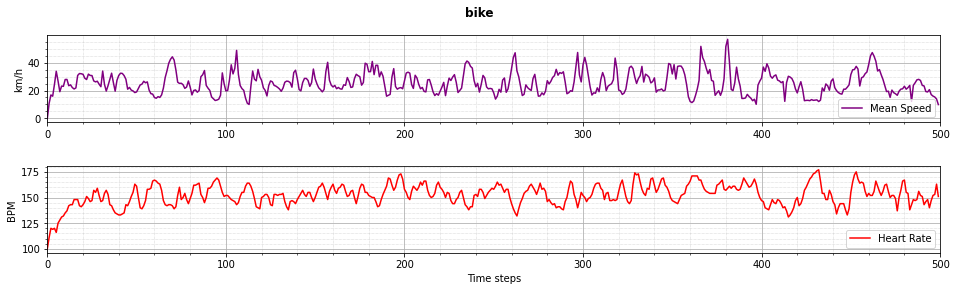

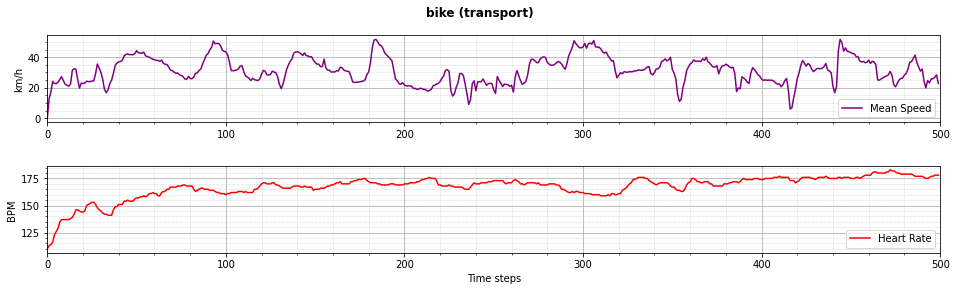

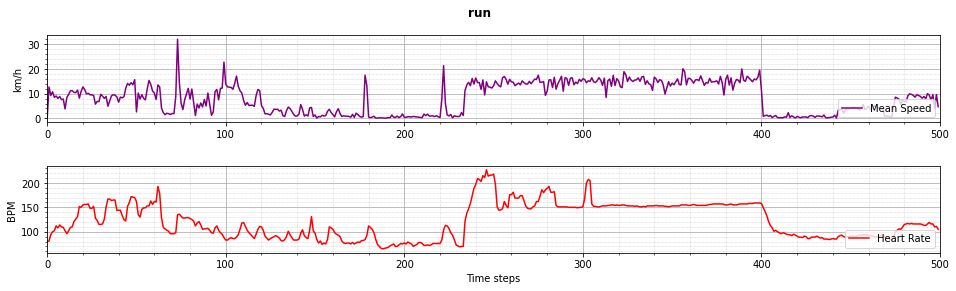

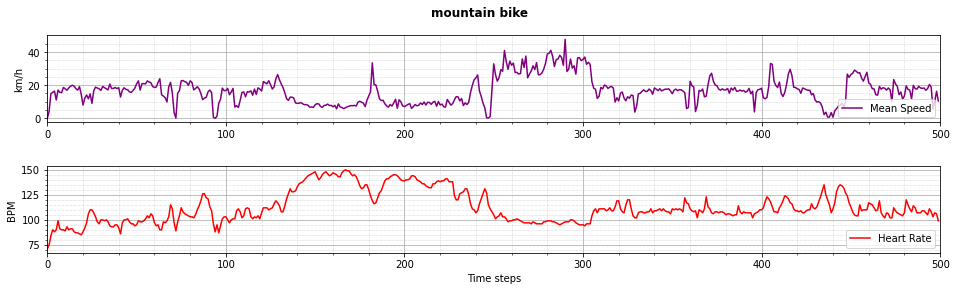

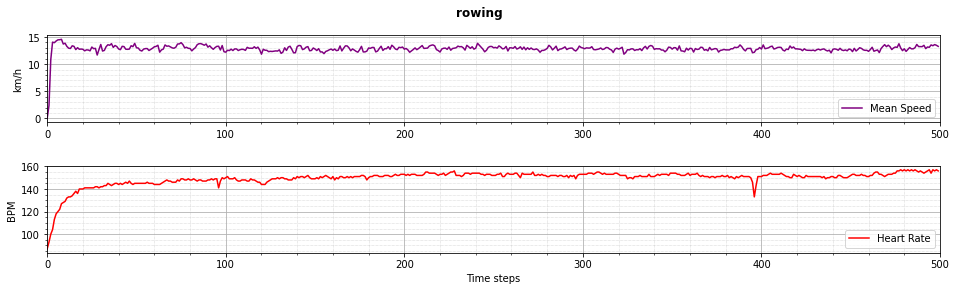

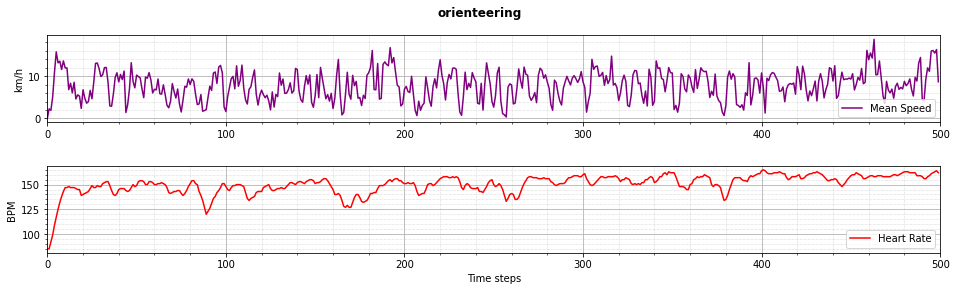

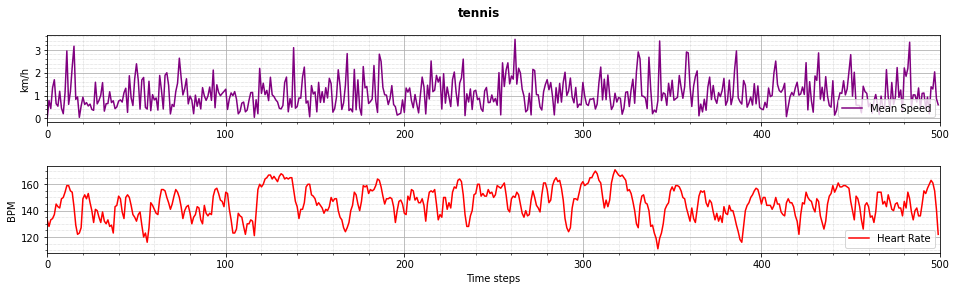

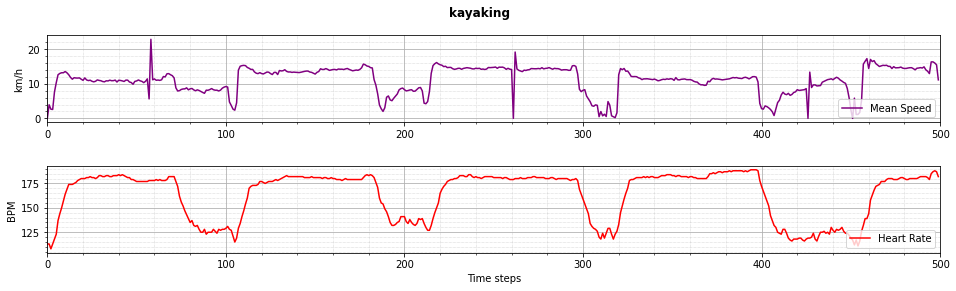

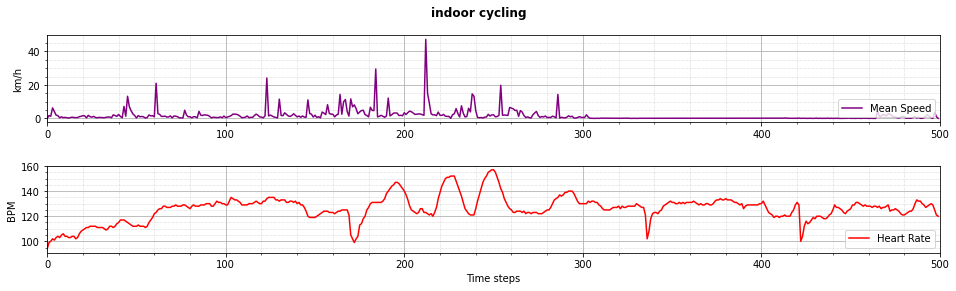

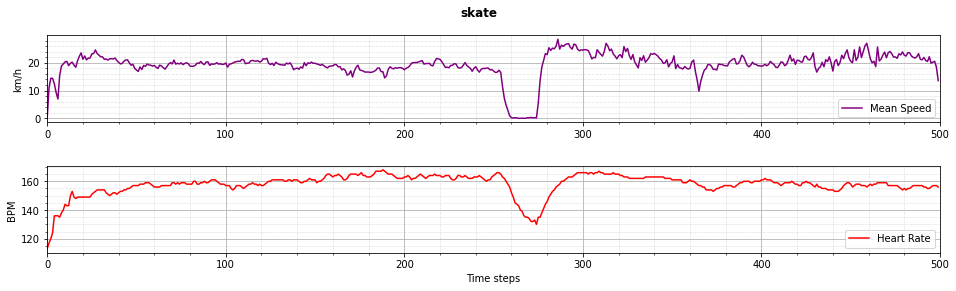

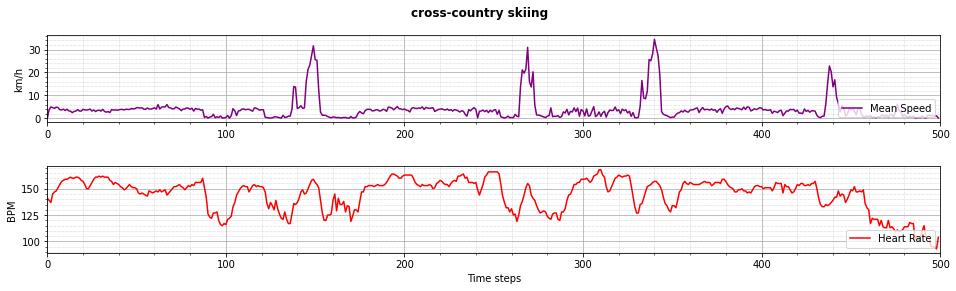

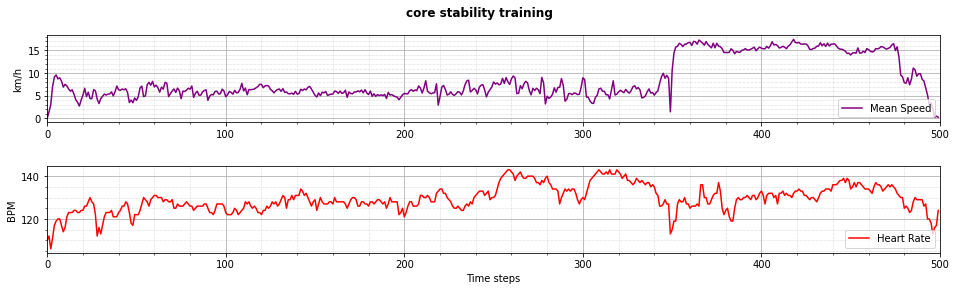

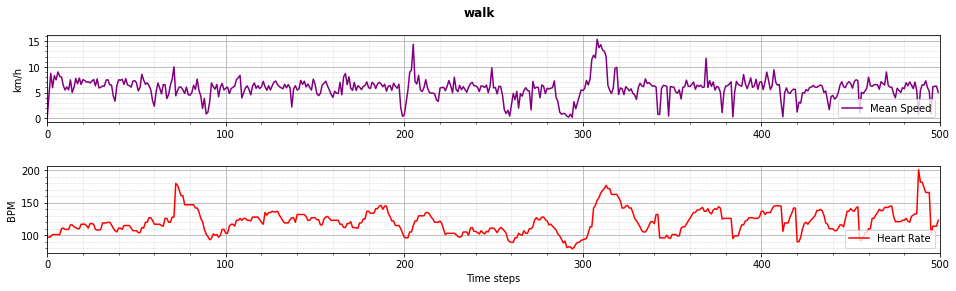

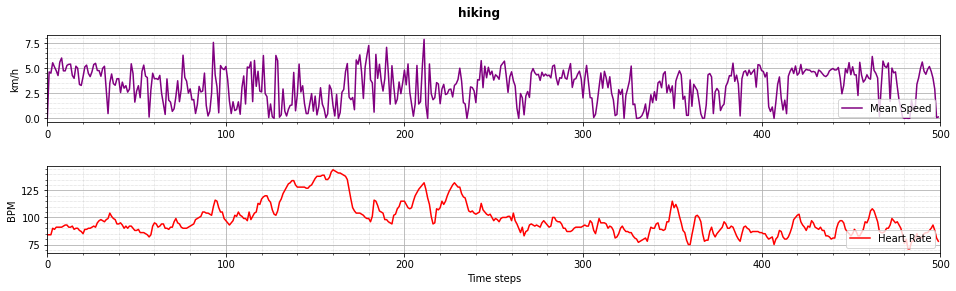

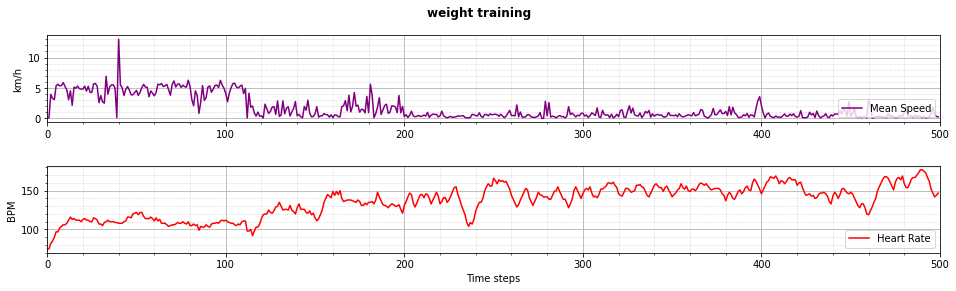

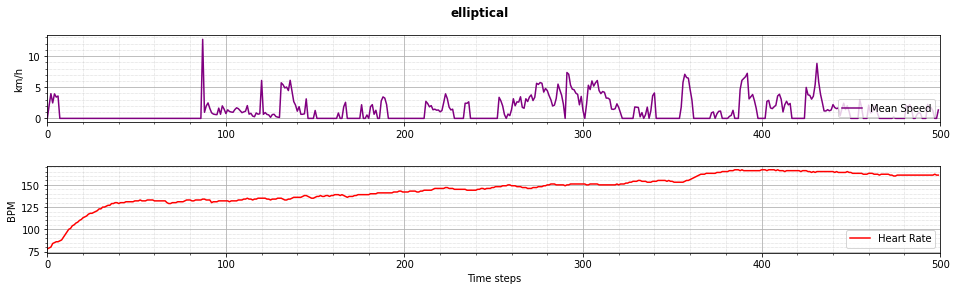

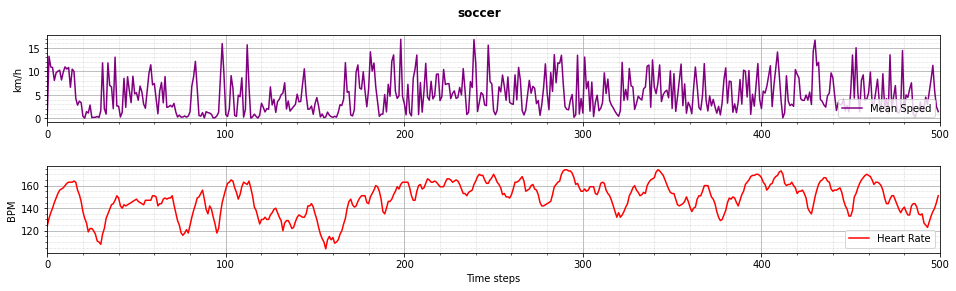

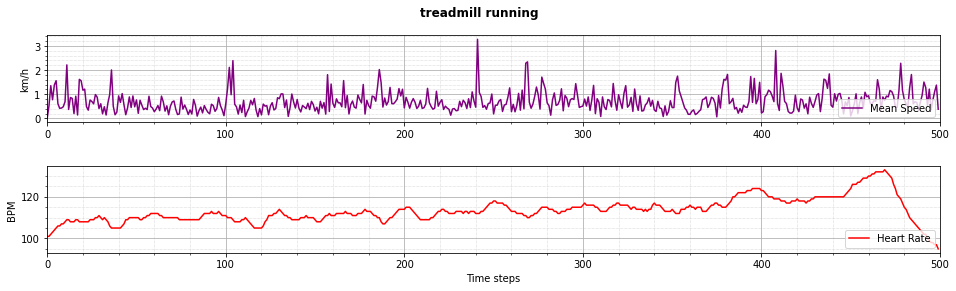

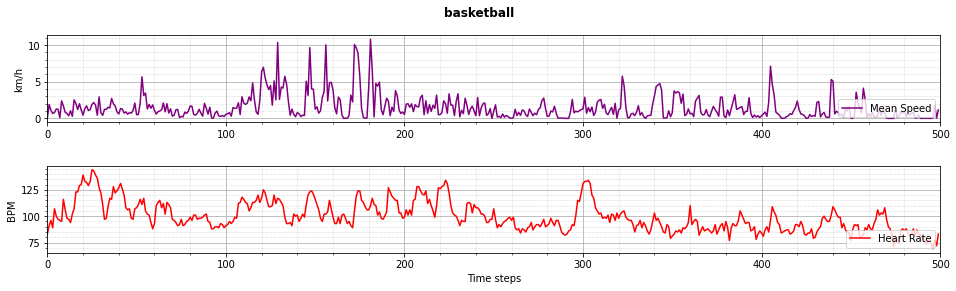

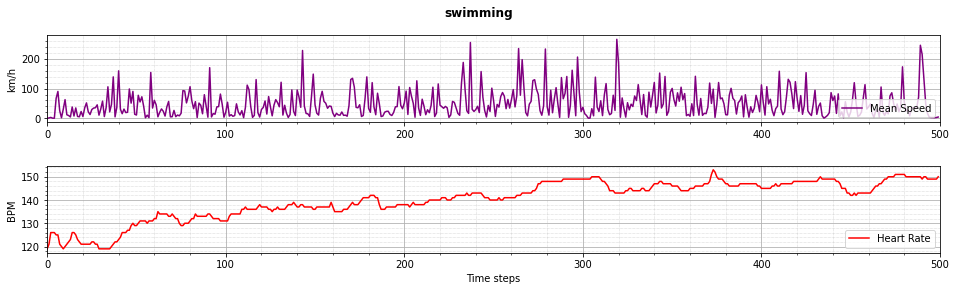

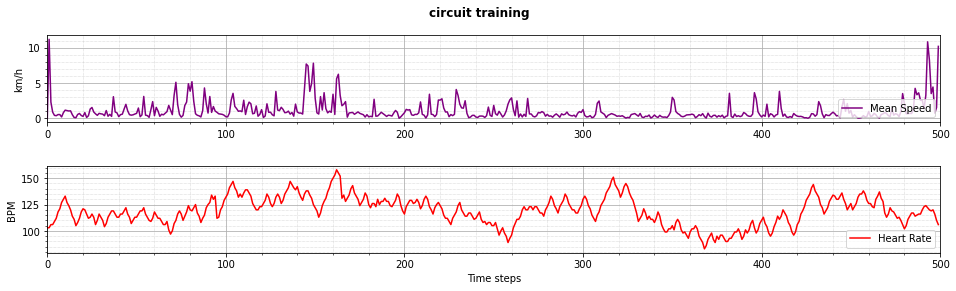

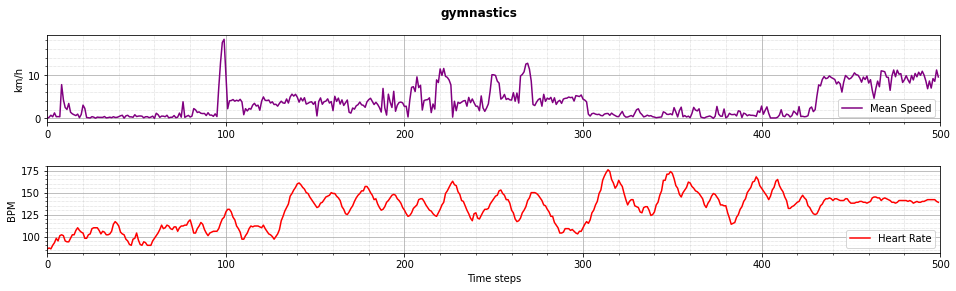

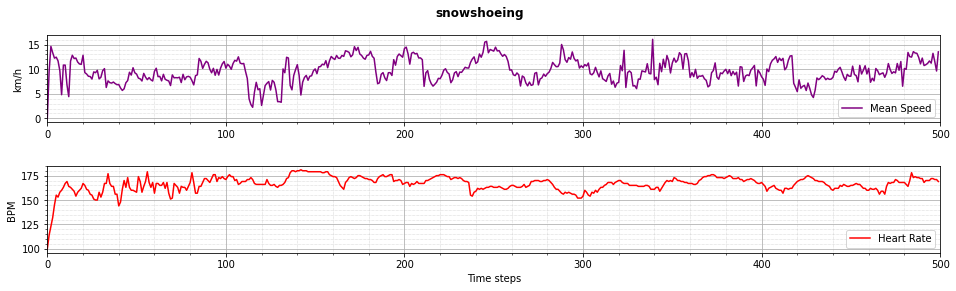

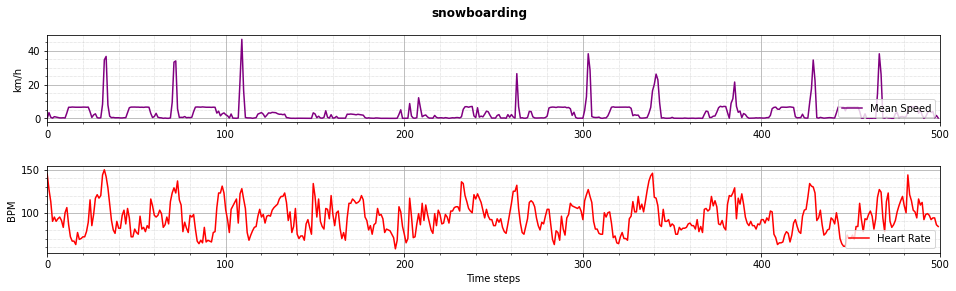

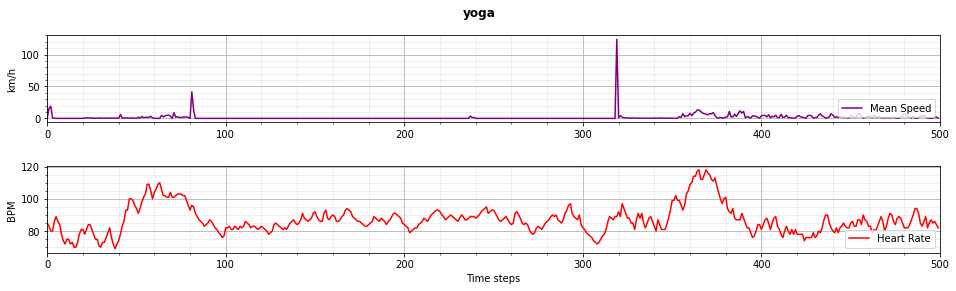

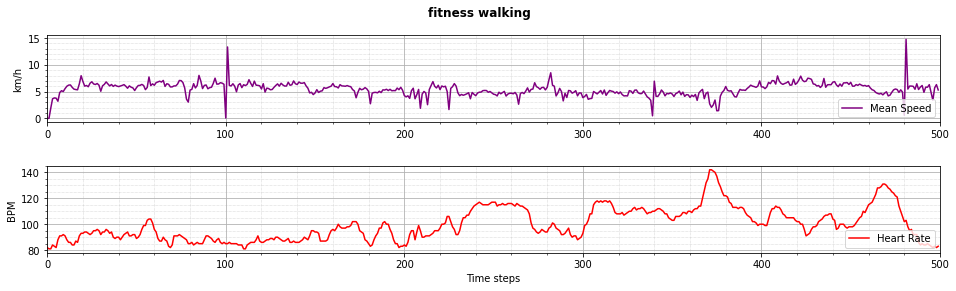

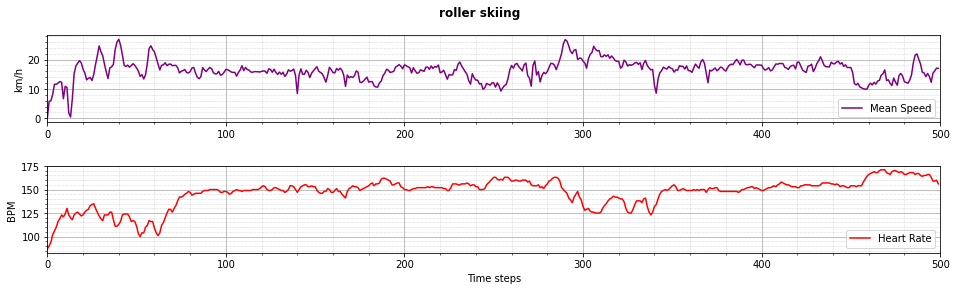

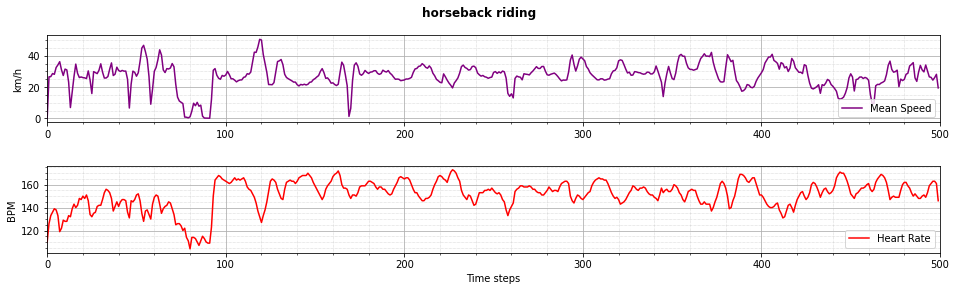

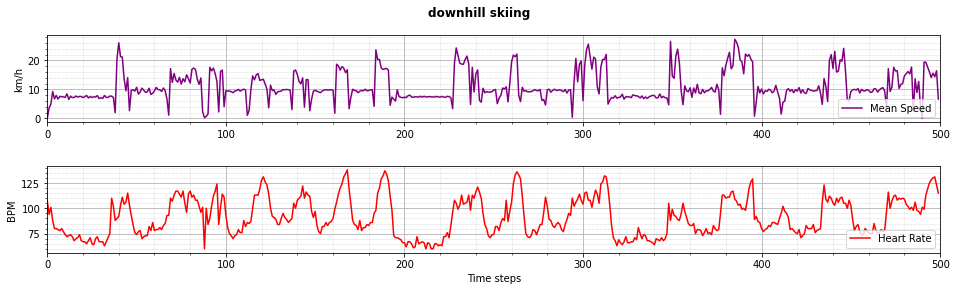

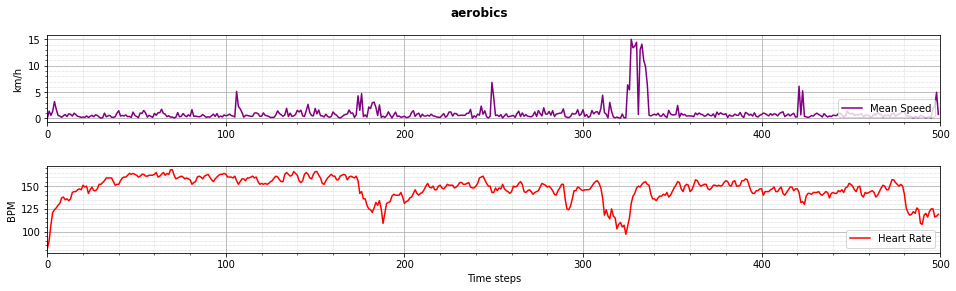

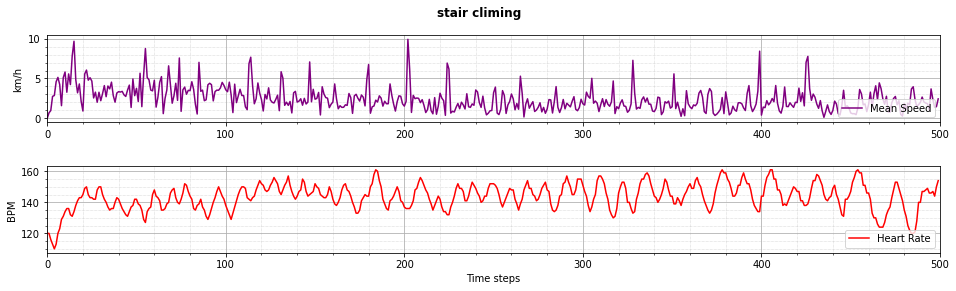

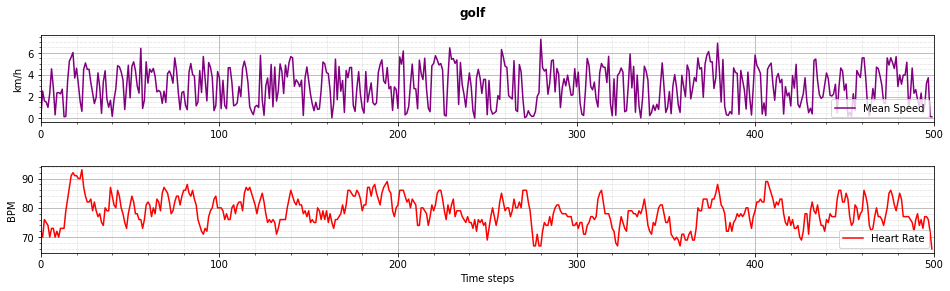

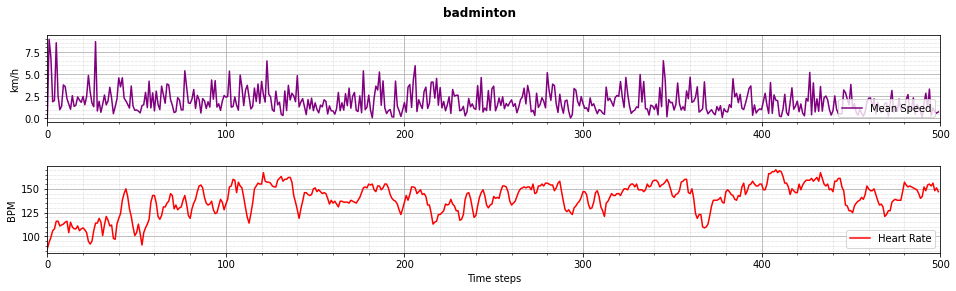

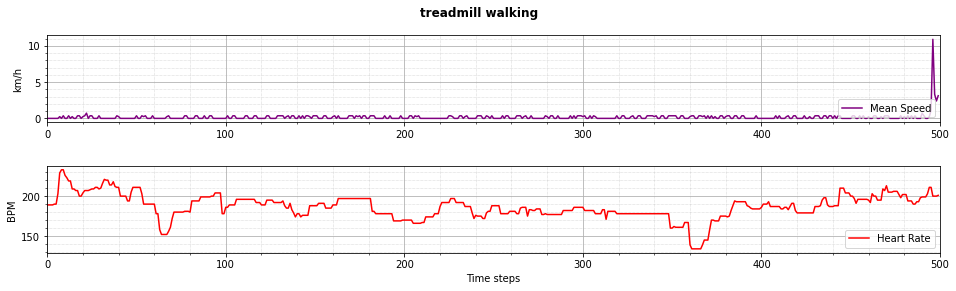

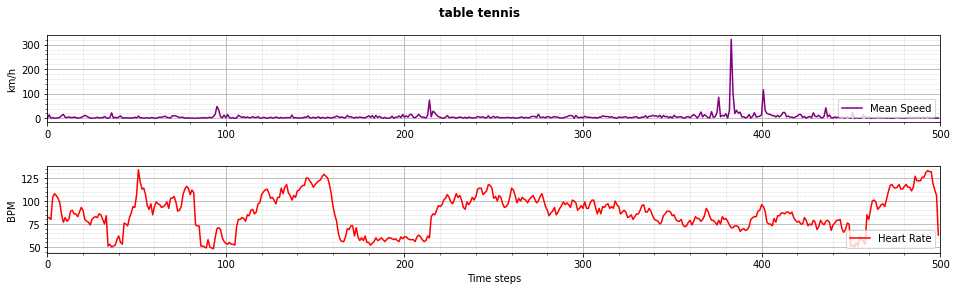

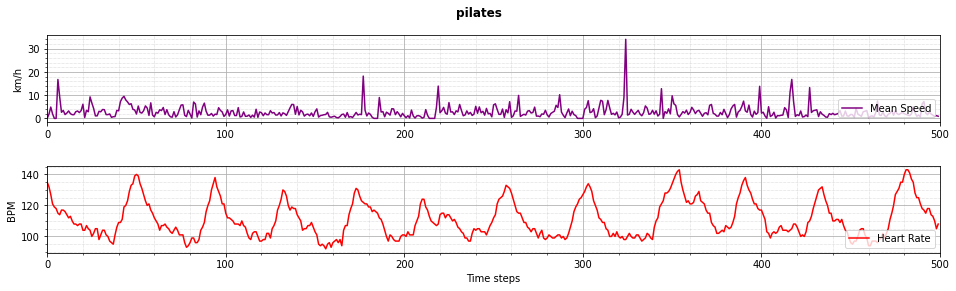

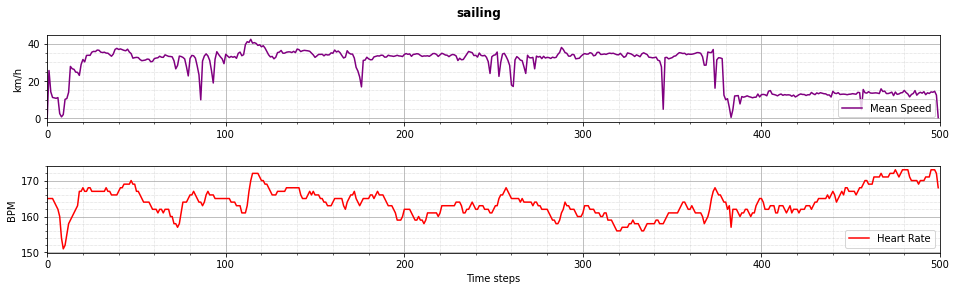

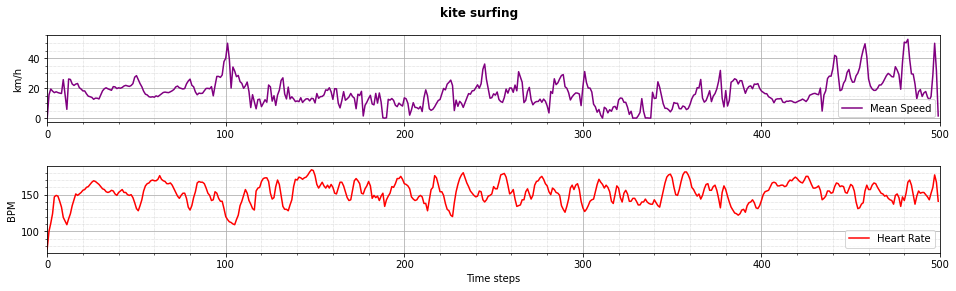

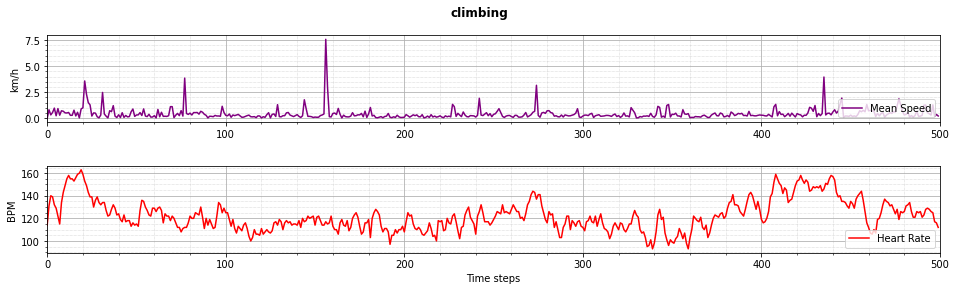

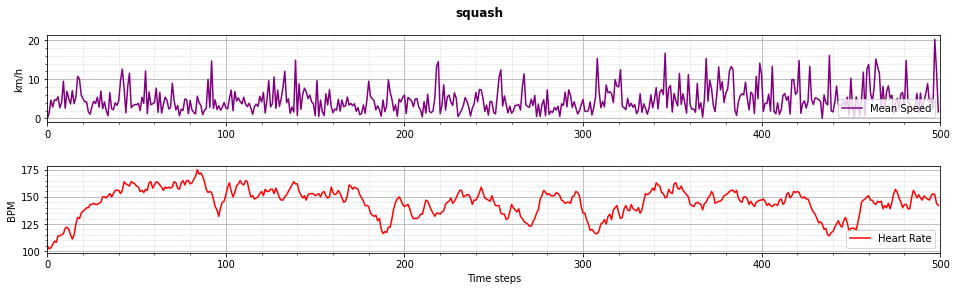

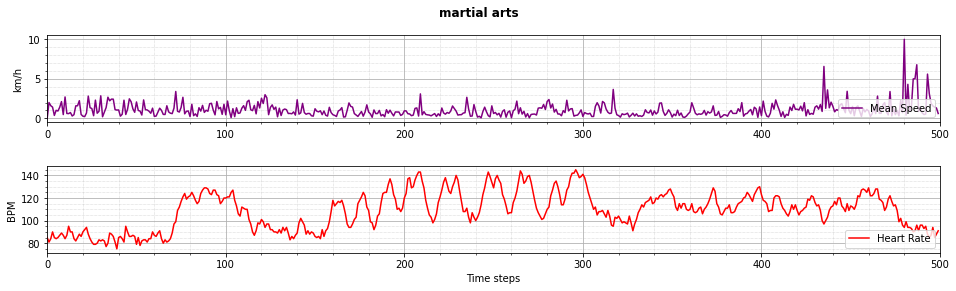

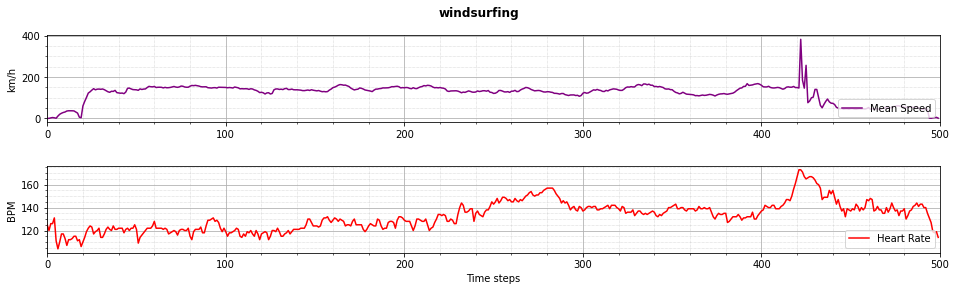

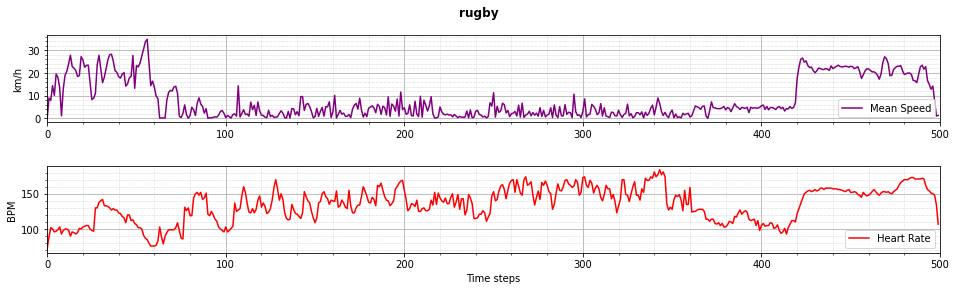

In [79]:
import os

# plot mean_speed heart_rate for each sports type
keys_to_plot = ['mean_speed', 'heart_rate']

for index, sport in enumerate(list(dict_sport_examples.keys())):
    sample = dict_sport_examples[sport]
    sample['sport'] = sport
    
    current_plot = EndomondoPlotter.plot_time_series([sample], keys_to_plot)
    axs[index//nr_rows, index%nr_cols] = current_plot
    
    # save plot
    output_file = os.path.join(r'F:\datasets\endomondoPlots', sport + '.png')
    plt.savefig(output_file, dpi=150)

In [8]:
# get the available data channels (=keys) of the given dataset
available_keys = EndomondoData.get_available_datachannels()
print('Available keys: \n{}'.format(available_keys))

Available keys: 
['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'timestamp', 'url', 'userId', 'speed', 'mean_speed']


### DataExplorer

This is a utility which allows to plot time series data. It is especially used to plot the channels of heart_rate and mean_speed.

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import os

In [15]:
class Endomondo_DataExplorer():
    def __init__(self, available_keys):
        self.available_keys = available_keys
        
    def _get_color_and_unit_for_key(self, current_key):
        if current_key == 'heart_rate':
            return 'red', 'BPM', 'Heart Rate'
        elif current_key == 'speed':
            return 'darkorange', 'km/h', 'Speed'
        elif current_key == 'mean_speed':
            return 'purple', 'km/h', 'Mean Speed'
        else:
            return 'forestgreen', None, 'UNK'
    
    def plot_time_series(self, Endomondo_json_object, plotted_keys, returning_plot=False):
        sport = Endomondo_json_object[0]['sport']
        nr_plotted_keys = len(plotted_keys)    
    
        fig, axs = plt.subplots(nr_plotted_keys, 1, figsize=(16,4))
        plt.subplots_adjust(hspace = .5)
        plt.suptitle(sport, fontweight="bold")
        
        for keyidx, key in enumerate(plotted_keys):
            #print('Selected key: {}'.format(key))
            key_color, unit, label = self._get_color_and_unit_for_key(key)
            
            data = np.array(Endomondo_json_object[0][key])
            time_steps = np.arange(0, data.shape[0])
            
            # plot properties
            axs[keyidx].plot(time_steps, data, key_color) 
            axs[keyidx].set_xlim([time_steps[0], time_steps[-1]+1])  
            if keyidx == nr_plotted_keys-1:
                axs[keyidx].set_xlabel('Time steps')
            axs[keyidx].set_ylabel(unit)
            axs[keyidx].minorticks_on()                                                                                         
            axs[keyidx].grid(True, which='major')                                                                               
            axs[keyidx].grid(True, which='minor', linestyle=":", linewidth=0.5)
            
            axs[keyidx].legend((label,), loc=4)
        
        if returning_plot:
            return fig

In [16]:
EndomondoPlotter = Endomondo_DataExplorer(available_keys)

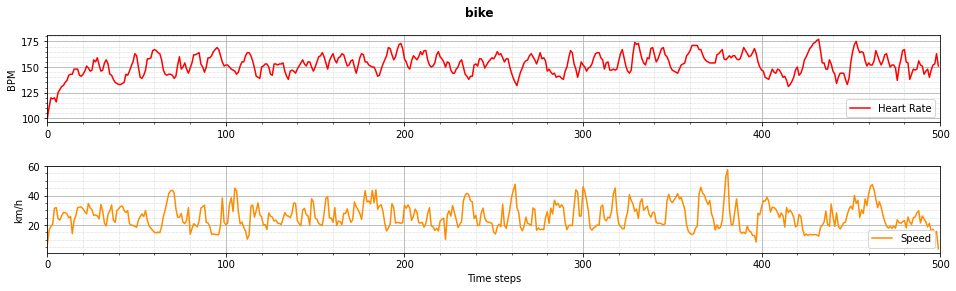

In [17]:
# plot heart rate and speed

keys_to_plot = ['heart_rate', 'speed']
fitness_sample_bike = EndomondoData.load_number_of_fitness_samples(nr_maximum_sample=1)

sample_plot = EndomondoPlotter.plot_time_series(fitness_sample_bike, keys_to_plot, returning_plot=True)

# save plot
output_file = os.path.join(r'F:\datasets\endomondoPlots', 'bikeSamplePlot' + '.png')
plt.savefig(output_file, dpi=150)

### Testing New Dataset (mean_speed calculation)

As the original dataset has lots of missing speed time series, I have computed an additional column to get the mean speed of each timestep of all given time series in the dataset (see the generation code below). This is a script to plot the old speed series and the newly generated mean_speed one. Use this plotting function as a consistency check.

[{'longitude': [24.64977040886879, 24.65014273300767, 24.650910682976246, 24.650668865069747, 24.649145286530256, 24.648349760100245, 24.645312326028943, 24.6447014529258, 24.644415881484747, 24.641415160149336, 24.63826850987971, 24.636211171746254, 24.634060626849532, 24.63249195367098, 24.631360983476043, 24.629418225958943, 24.625693140551448, 24.62388290092349, 24.621391966938972, 24.62025227956474, 24.61888753809035, 24.617006219923496, 24.615299999713898, 24.614676302298903, 24.612943679094315, 24.61235510185361, 24.61154105141759, 24.610843928530812, 24.61042357608676, 24.60953777655959, 24.608315024524927, 24.606816424056888, 24.605027558282018, 24.603541865944862, 24.602169329300523, 24.600177453830838, 24.599060313776135, 24.597142953425646, 24.596376596018672, 24.594232169911265, 24.592483872547746, 24.591050064191222, 24.589767884463072, 24.58789142780006, 24.583472656086087, 24.582278402522206, 24.580545527860522, 24.579513799399137, 24.57896520383656, 24.57808376289904, 

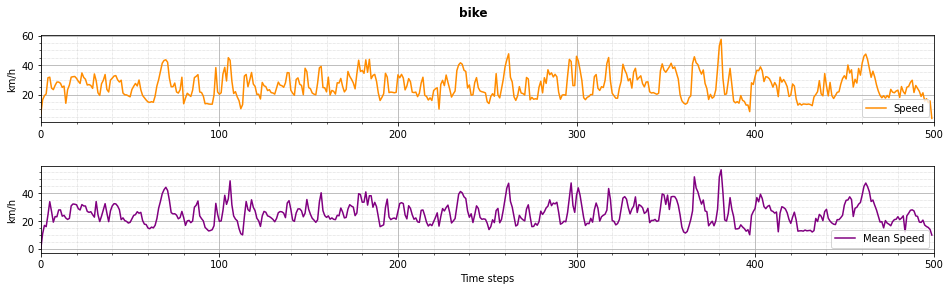

In [19]:
datafile = r'F:\datasets\endomondoHR_proper_meanspeed.json'
EndomondoDataMeanSpeed = Endomondo_DataLoader(datafile)

sample = [EndomondoDataMeanSpeed.load_number_of_fitness_samples(nr_maximum_sample=1)[0]]
print(sample)
keys_to_plot = ['speed', 'mean_speed']
sample_plot = EndomondoPlotter.plot_time_series(sample, keys_to_plot, returning_plot=True)

# save plot
output_file = os.path.join(r'F:\datasets\endomondoPlots', 'bikeSampleSpeedvsMeanSpeed' + '.png')
plt.savefig(output_file, dpi=150)

### Correlation plot

Creating a sample correlation plot for each sports type (just for visualization, calculation of average correlation per class done in Endomondo_DataLoader utility).

<ipython-input-63-3fff05a23156>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


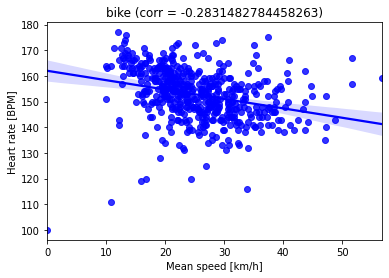

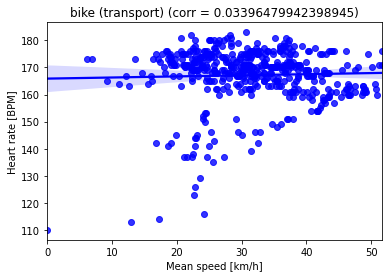

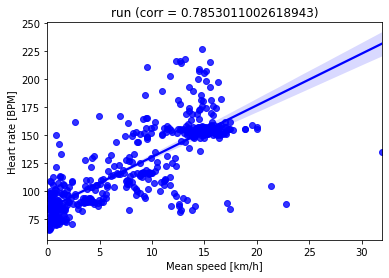

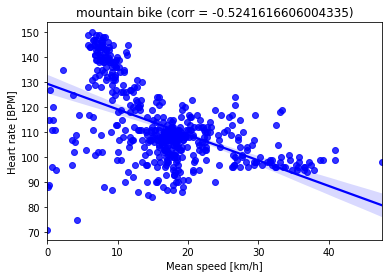

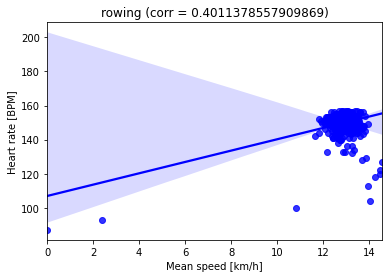

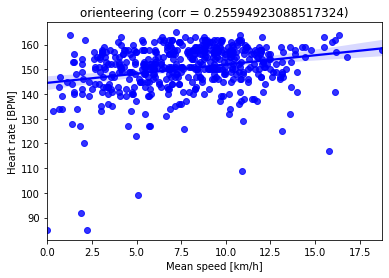

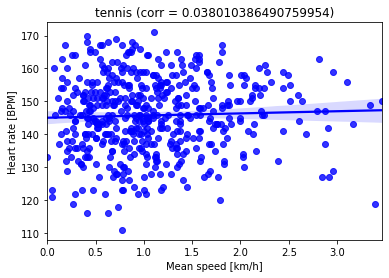

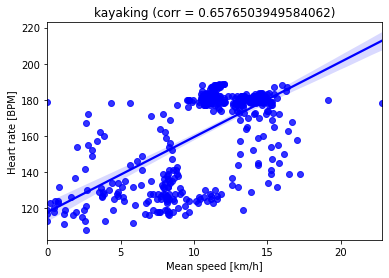

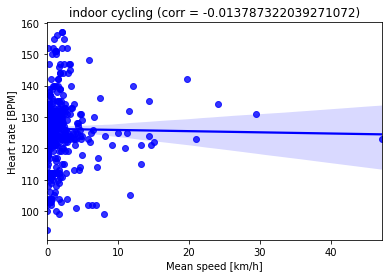

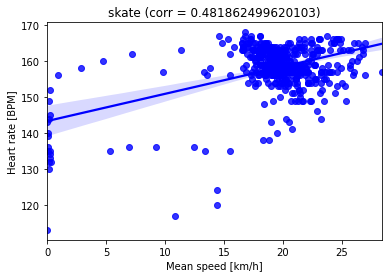

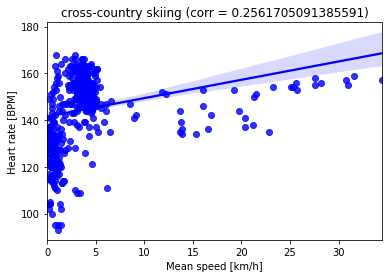

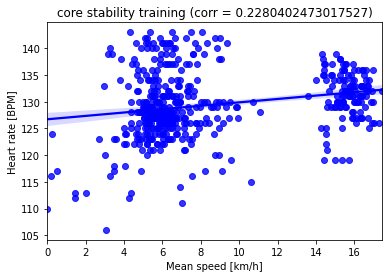

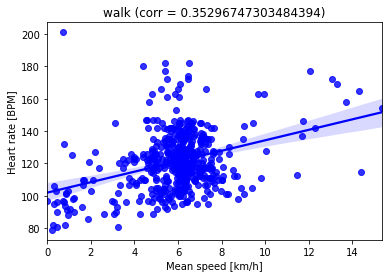

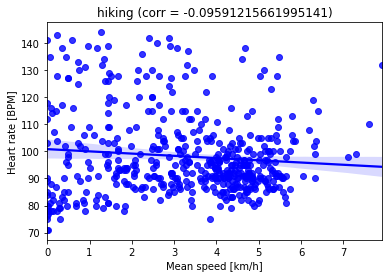

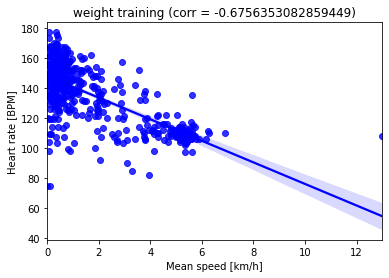

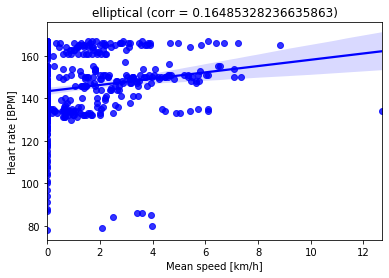

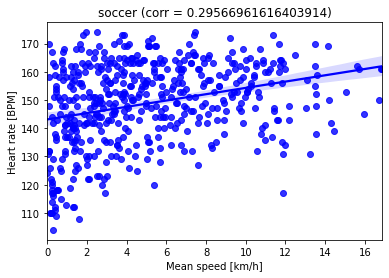

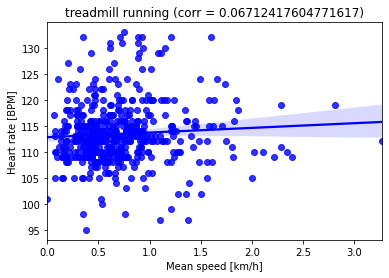

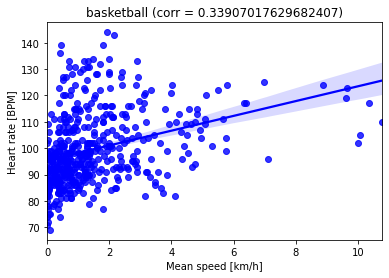

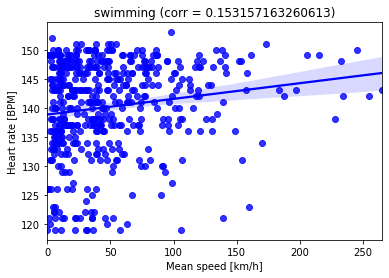

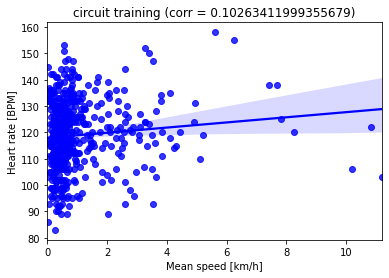

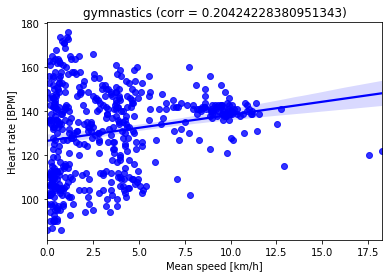

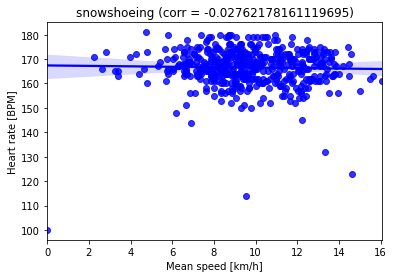

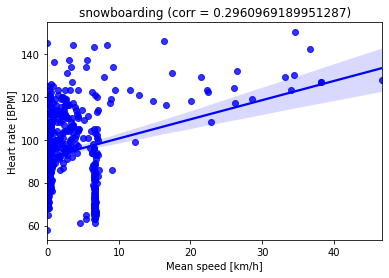

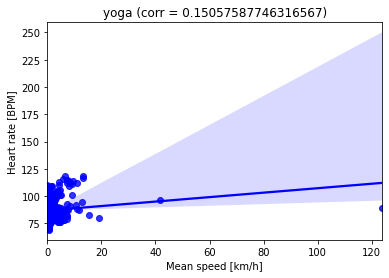

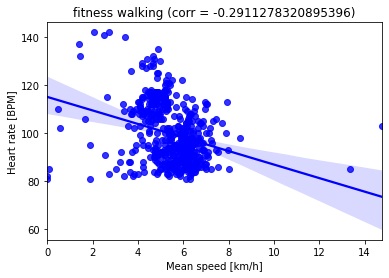

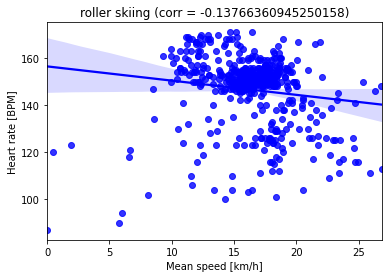

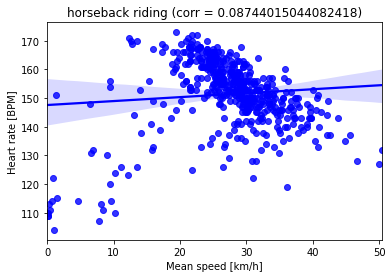

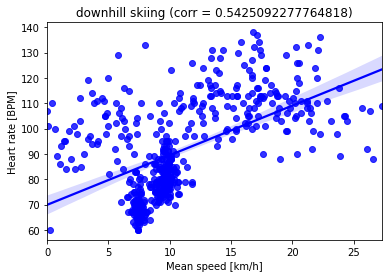

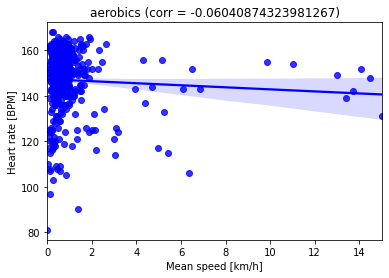

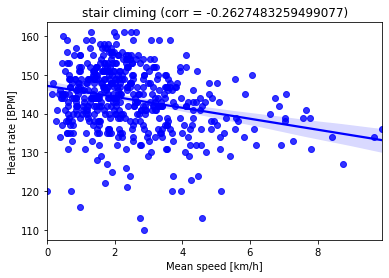

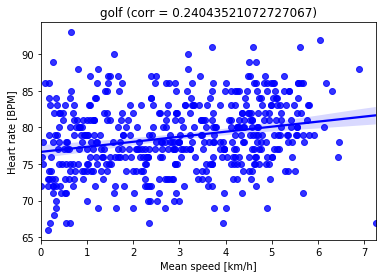

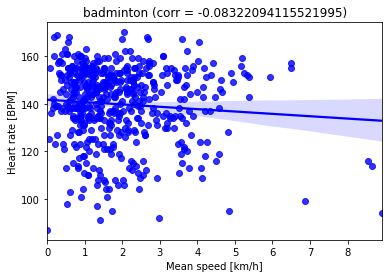

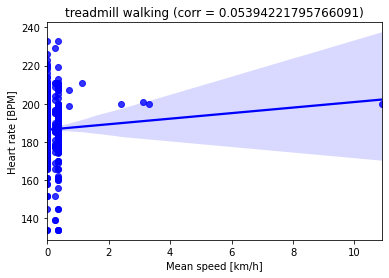

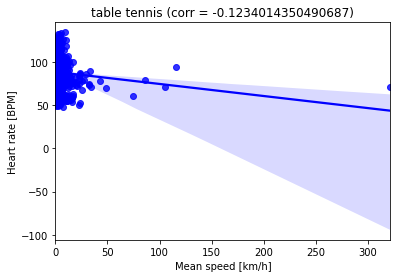

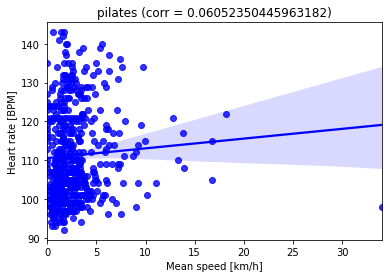

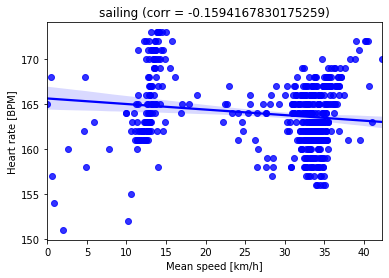

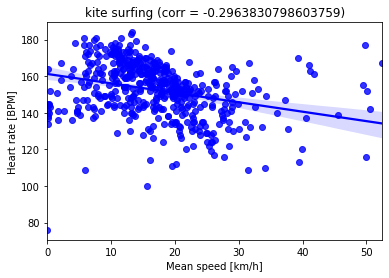

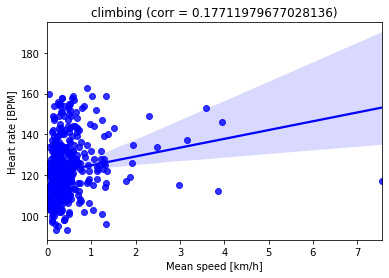

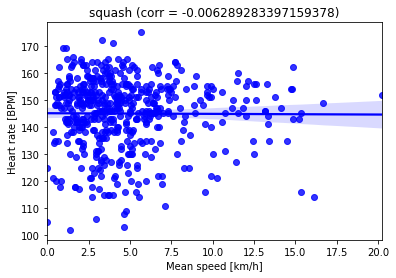

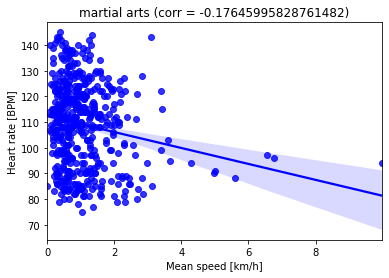

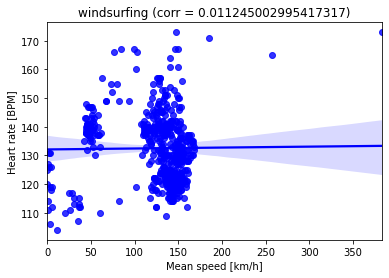

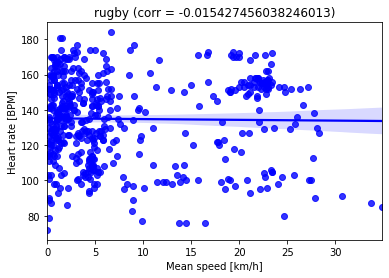

In [63]:
import os

for index, sport in enumerate(list(dict_sport_examples.keys())):
    sample = dict_sport_examples[sport]
    sample['sport'] = sport
    
    mean_speed = sample['mean_speed']
    heart_rate = sample['heart_rate']
    corr = np.corrcoef(np.array(mean_speed), np.array(heart_rate))[0, 1]
    
    plt.figure()
    sns.regplot(x=mean_speed, y=heart_rate, color="b").set_title(sport + ' (corr = ' + str(corr) + ')')
    plt.xlabel('Mean speed [km/h]')
    plt.ylabel('Heart rate [BPM]')
    
    output_file = os.path.join(r'F:\datasets\endomondoPlots', 'corr_' + sport + '.png')
    plt.savefig(output_file, dpi=150)

### Data Creation (`mean_speed` column)

As the original dataset had lots of missing speed values, use this functionality to create a `mean_speed` column. It will use the Haversine algorithm to calculate the distance between two GPS coordiantes (and include the altitude difference) between two timestamps for each sample in the dataset.

Note that this data adjustment is saved as a separate dataset on my personal Google Drive, https://docs.google.com/uc?export=download&id=1-2Zhh_ndLZLpcPNC64629qaDvsIXO4Vx.

In [ ]:
%pip install haversine
%pip install tqdm

In [ ]:
from haversine import haversine

import numpy as np
import json
from pprint import *

from tqdm.notebook import tqdm

In [ ]:
datafile = "/content/drive/MyDrive/endomondoHR_proper.json"
EndomondoData = Endomondo_DataLoader(datafile)  # use DataLoader from above

In [ ]:
def calculate_mean_speed(sample):
    lat = sample['latitude']
    lon = sample['longitude']
    alt = sample['altitude']
    timestamp = sample['timestamp']

    mean_speed = []

    for idx in range(len(lat)-1):
        lat2, lat1 = lat[idx+1],lat[idx]
        lon2, lon1 = lon[idx+1], lon[idx]
        alt2, alt1 = alt[idx+1], alt[idx]
        time = (timestamp[idx+1] - timestamp[idx])/3600  # sec to hour
        
        if time < 1/3600:
            time = 1/3600

        flat_distance = haversine((lat2, lon2), (lat1, lon1))
        height_distance = (alt2-alt1)/1000  # in km
        total_distance = np.sqrt(flat_distance*flat_distance + height_distance*height_distance)
        speed = total_distance/time

        mean_speed.append(round(speed, 4))

    # add first value of time series (e.g. as copy of the first calculated value or BETTER: to zero as starting velocity) (needed for initialisation and to obtain same time series length)
    mean_speed.insert(0, 0.0)

    return mean_speed

In [ ]:
new_dataset = []

with open("/content/drive/MyDrive/endomondoHR_proper.json", encoding='utf8') as file:
    for index, line in  tqdm(enumerate(file), total=167783, leave=True):
        # json only supports double quotations
        line = line.replace("\'", "\"")  

        # save properties of json object
        sample = json.loads(line)
        mean_speed = calculate_mean_speed(sample)
        sample["mean_speed"] = mean_speed

        new_dataset.append(sample)